In [5]:
from load_sim_data import *
from load_shp import *
from sim_eval_pkg import *

In [6]:
def prepare_data(data_array):
    array = data_array.values.flatten()
    array = array[~np.isnan(array)]
    array = array[array>0]
    return array

def compute_boxplot_stats(data):
    stats = {
        'med': np.percentile(data, 50),
        'q1': np.percentile(data, 25),
        'q3': np.percentile(data, 75),
        'whislo': np.percentile(data, 1),   
        'whishi': np.percentile(data, 99),
        'mean': np.nanmean(data),
        'std': np.nanstd(data)
    }
    return stats

In [9]:
def extract_mod_obs_10cities(var_name, obs_xr, period='JJA'):
    ctrl=(eval(f'ctrl_{period}_avg_1d32deg_reg')[var_name])
    test=(eval(f'test_{period}_avg_1d32deg_reg')[var_name])
    obs=obs_xr+273.15
    mask=(ctrl>0) & (obs>0) & (test>0)
    ctrl=ctrl.where(mask)
    test=test.where(mask)
    obs=obs.where(mask)
    
    city_array = {}
    city_stats = {}
    
    datasets = [
        {'name': 'ctrl', 'variable': ctrl, 'color': '#9fc5e8'},
        {'name': 'test', 'variable': test, 'color': '#f4cccc'},
        {'name': 'obs', 'variable': obs, 'color': '#93c47d'}
    ]
    
    all_boxplot_data = []
    colors_for_boxes = []
    positions = []
    city_positions = []
    pos = 1 
    
    for city in PRISM_cities:
        city_name = city['name']
        city_shapefile = city['shapefile']
        city_waterFrac = city['water']
        for dataset in datasets:
            dataset_name = dataset['name']
            dataset_variable = dataset['variable']
            color = dataset['color']
    
            clipped_data = clip_netcdf_by_shp(dataset_variable, city_shapefile).where(city_waterFrac>0.0)
            data_array = prepare_data(clipped_data)
            city_array[(city_name,dataset_name)]=data_array
    
            if dataset_name == 'obs':
                obs_data = data_array
                ctrl_data = city_array.get((city_name, 'ctrl'))
                test_data = city_array.get((city_name, 'test'))
                
                if ctrl_data is not None and test_data is not None:
                    mask_ctrl = (~np.isnan(ctrl_data)) & (~np.isnan(obs_data)) & (~np.isnan(test_data))
                    #mask_test = (~np.isnan(test_data)) & (~np.isnan(obs_data))
                    
                    ctrl_vals = ctrl_data[mask_ctrl].flatten()
                    test_vals = test_data[mask_ctrl].flatten()
                    obs_vals_ctrl = obs_data[mask_ctrl].flatten()
                    obs_vals_test = obs_data[mask_ctrl].flatten()
            
                    if len(ctrl_vals) > 0 and len(obs_vals_ctrl) > 0:
                        R_ctrl, _ = pearsonr(ctrl_vals, obs_vals_ctrl)
                        RMSE_ctrl = np.sqrt(mean_squared_error(obs_vals_ctrl, ctrl_vals))
                        MAE_ctrl = mean_absolute_error(obs_vals_ctrl, ctrl_vals)
                    else:
                        R_ctrl, RMSE_ctrl, MAE_ctrl = np.nan, np.nan, np.nan
            
                    if len(test_vals) > 0 and len(obs_vals_test) > 0:
                        R_test, _ = pearsonr(test_vals, obs_vals_test)
                        RMSE_test = np.sqrt(mean_squared_error(obs_vals_test, test_vals))
                        MAE_test = mean_absolute_error(obs_vals_test, test_vals)
                    else:
                        R_test, RMSE_test, MAE_test = np.nan, np.nan, np.nan
            
                    city_stats[city_name] = {
                        'R_ctrl': R_ctrl,
                        'RMSE_ctrl': RMSE_ctrl,
                        'MAE_ctrl': MAE_ctrl,
                        'R_test': R_test,
                        'RMSE_test': RMSE_test,
                        'MAE_test': MAE_test
                    }
    
            stats = compute_boxplot_stats(data_array)
            box_data = {
                'med': stats['med'],
                'q1': stats['q1'],
                'q3': stats['q3'],
                'whislo': stats['whislo'],
                'whishi': stats['whishi'],
                'fliers': []
            }
            all_boxplot_data.append(box_data)
            colors_for_boxes.append(color)
            positions.append(pos)
            pos += 1
        city_positions.append(pos - 2)
        pos += 0.5

    return all_boxplot_data, colors_for_boxes, positions, city_positions, city_stats

In [10]:
def boxplot_PRISM(var_name, obs_xr, ylabel, period):
    all_boxplot_data, colors_for_boxes, positions, city_positions, city_stats=extract_mod_obs_10cities(var_name, obs_xr, period)
    fig, ax = plt.subplots(figsize=(15, 8))
    boxplot = ax.bxp(all_boxplot_data, positions=positions, showfliers=False, patch_artist=True,widths=0.7)
    
    num_boxes = len(boxplot['boxes'])
    for i in range(num_boxes):
        box = boxplot['boxes'][i]
        whisker_left = boxplot['whiskers'][2 * i]
        whisker_right = boxplot['whiskers'][2 * i + 1]
        cap_left = boxplot['caps'][2 * i]
        cap_right = boxplot['caps'][2 * i + 1]
        median = boxplot['medians'][i]
        
        color = colors_for_boxes[i]
        
        box.set_facecolor('none')        
        box.set_edgecolor(color)         
        box.set_linewidth(3)          
        
        # Set whisker properties
        whisker_left.set_color(color)
        whisker_right.set_color(color)
        whisker_left.set_linewidth(3)
        whisker_right.set_linewidth(3)
        whisker_left.set_linestyle('dashed')    # Set left whisker to dashed line
        whisker_right.set_linestyle('dashed') 
        
        # Set cap properties
        cap_left.set_color(color)
        cap_right.set_color(color)
        cap_left.set_linewidth(3)
        cap_right.set_linewidth(3)
        
        median.set_color(color)
        median.set_linewidth(2.5)
    
    ax.set_xticks(city_positions)
    ax.set_xticklabels([city['name'] for city in PRISM_cities], ha='center',fontsize=28)
    
    ax.set_ylabel(ylabel,fontsize=24)
    ax.tick_params(axis='y', labelsize=20)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax.set_title('')
    
    legend_handles = [
        mpatches.Patch(facecolor='none', edgecolor='#9fc5e8', label='CTRL', linewidth=3),
        mpatches.Patch(facecolor='none', edgecolor='#f4cccc', label='USURF', linewidth=3),
        mpatches.Patch(facecolor='none', edgecolor='#93c47d', label='PRISM', linewidth=3)
    ]
    ax.legend(handles=legend_handles,fontsize=20)
    
    plt.tight_layout()

    city_stats = pd.DataFrame(city_stats)
    city_stats['average'] = city_stats.mean(axis=1)
    return fig, city_stats

,PHX,LAX,CHI,DNV,POR,BAL,MIA,DAL,BOS,ATL,average
R_ctrl,0.270020,-0.603522,0.791732,0.122890,0.602864,0.194219,0.279901,0.464332,0.417922,0.878884,0.341924
RMSE_ctrl,0.528602,1.830472,1.267921,1.527085,0.558683,1.353475,1.098802,1.379935,1.473129,1.477647,1.249575
MAE_ctrl,0.430439,1.623937,1.235852,1.297739,0.452920,1.222844,1.066348,1.302834,1.431425,1.466533,1.153087
R_test,0.324785,-0.642718,0.845604,0.151792,0.654414,0.199676,0.533347,0.228401,0.507110,0.877021,0.367943
RMSE_test,0.563302,1.866533,0.987459,1.613041,0.373192,1.030679,0.998914,1.238279,0.874094,1.196544,1.074203
MAE_test,0.474296,1.655980,0.956262,1.390889,0.309340,0.866907,0.969836,1.134080,0.810177,1.180640,0.974841


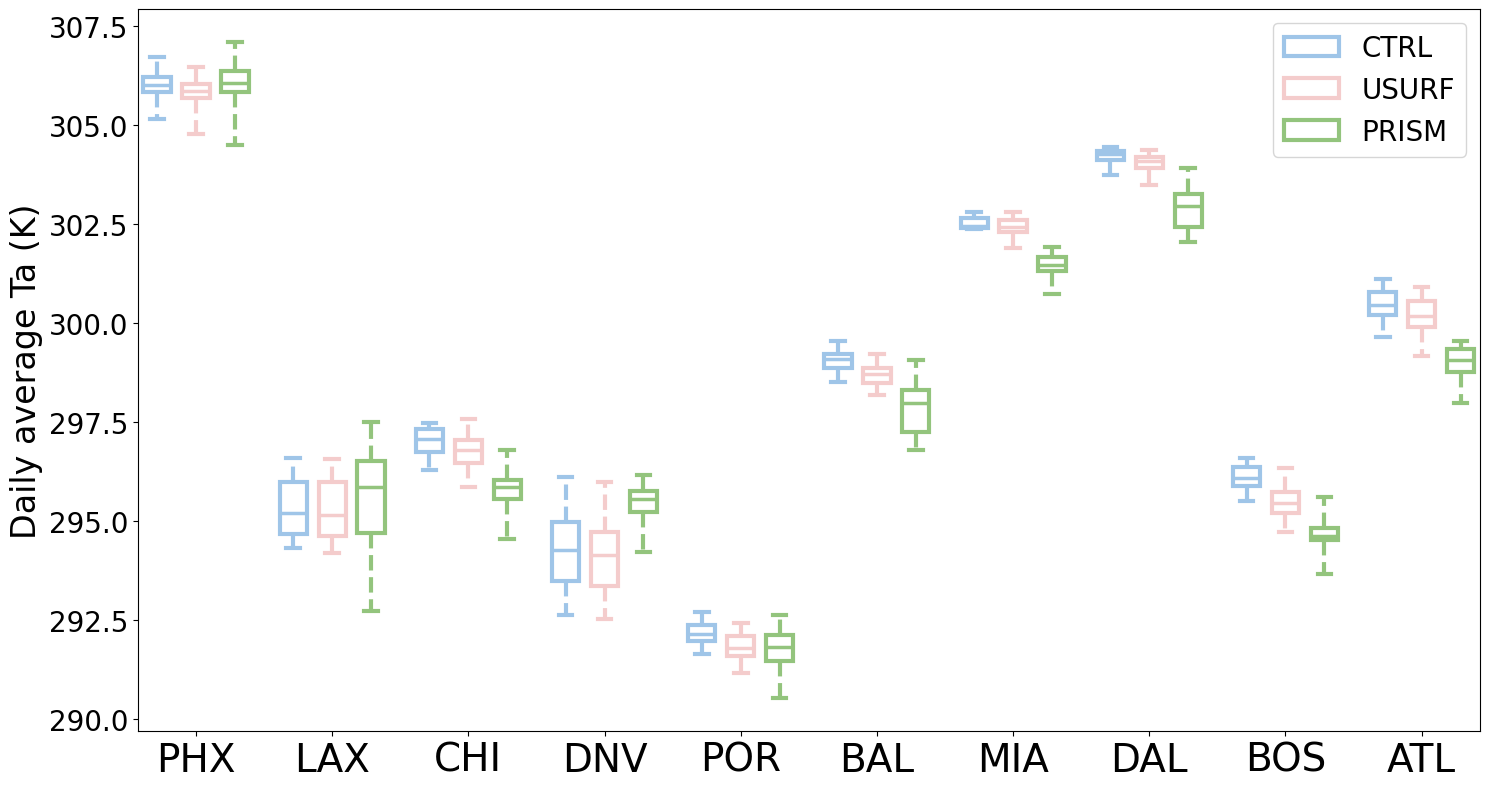

In [11]:
var_name='TSA_U'
ylabel='Daily average Ta (K)'
fig,city_stats=boxplot_PRISM(var_name, PRISM_JJA_xr, ylabel,'JJA')
fig.savefig(plot_path+'PRISM_CLM_2010_2014_JJA_daily_TSA_U_boxplot_waterMask_c250527.png', format='png', bbox_inches='tight', dpi=400)
city_stats

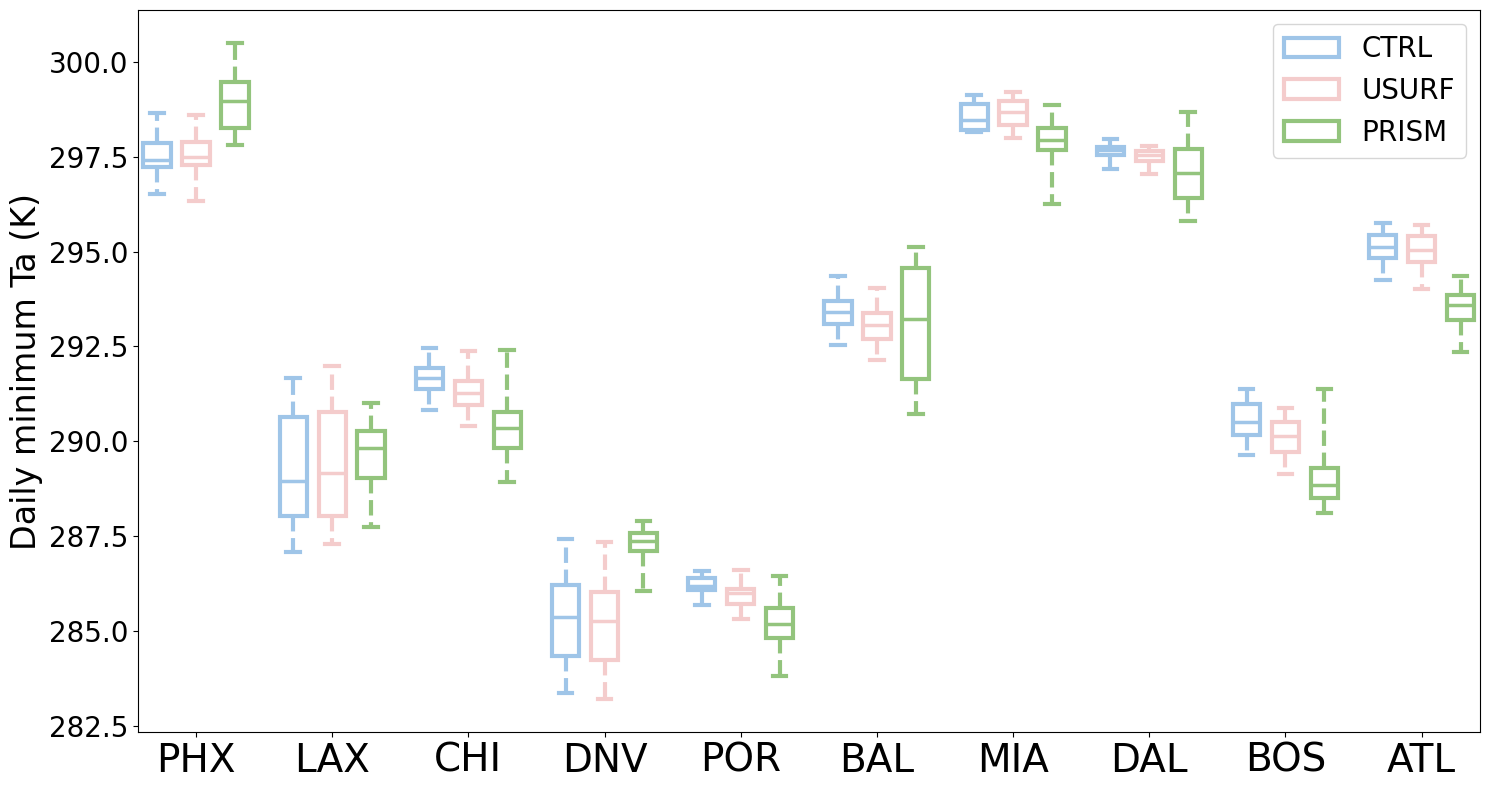

In [12]:
var_name='TREFMNAV_U'
ylabel='Daily minimum Ta (K)'
fig,city_stats=boxplot_PRISM(var_name, PRISM_JJA_Tmin_xr, ylabel,'JJA')
city_stats
fig.savefig(plot_path+'PRISM_CLM_2010_2014_JJA_daily_TREFMNAV_U_boxplot_waterMask_c250527.png', format='png', bbox_inches='tight', dpi=400)

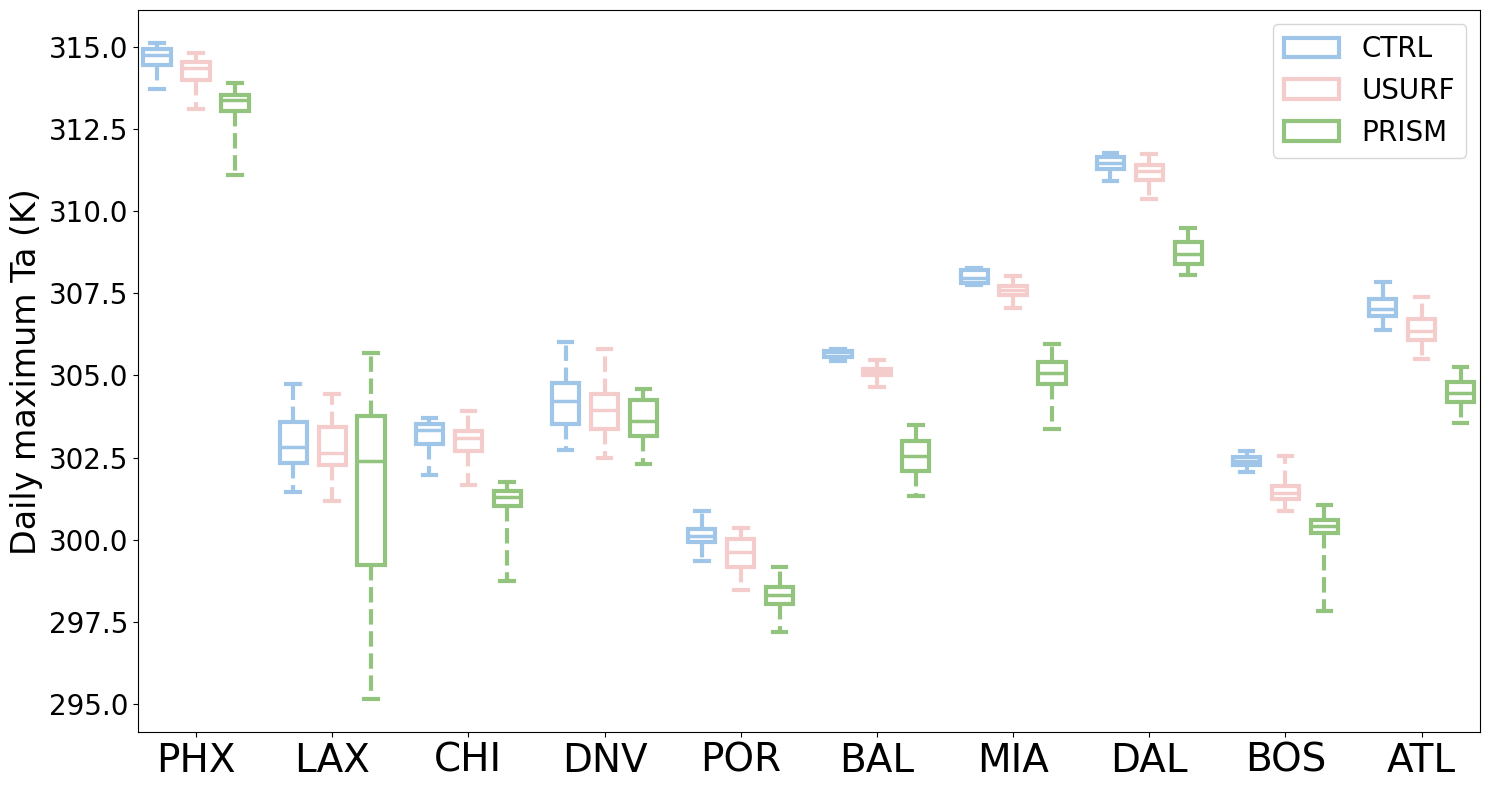

In [13]:
var_name='TREFMXAV_U'
ylabel='Daily maximum Ta (K)'
fig,city_stats=boxplot_PRISM(var_name, PRISM_JJA_Tmax_xr, ylabel,'JJA')
city_stats
fig.savefig(plot_path+'PRISM_CLM_2010_2014_JJA_daily_TREFMXAV_U_boxplot_waterMask_c250527.png', format='png', bbox_inches='tight', dpi=400)

,PHX,LAX,CHI,DNV,POR,BAL,MIA,DAL,BOS,ATL,average
R_ctrl,0.003474,0.290207,0.882995,-0.766715,0.220065,0.469098,0.789989,0.529782,0.871537,0.908098,0.419853
RMSE_ctrl,0.817885,2.306213,0.852108,1.494150,0.660575,0.703669,0.740161,0.789656,0.826490,1.047894,1.023880
MAE_ctrl,0.735863,1.981017,0.793556,1.244477,0.521463,0.577682,0.650581,0.713786,0.760343,1.027383,0.900615
R_test,0.002485,0.309590,0.902738,-0.703740,0.216981,0.567726,0.862266,0.578453,0.911718,0.903122,0.455134
RMSE_test,0.961352,2.440193,0.467700,1.921343,0.900077,0.440529,0.651086,0.539961,0.352592,0.678010,0.935284
MAE_test,0.856575,2.095965,0.407730,1.676183,0.766457,0.375779,0.566722,0.476705,0.299889,0.643775,0.816578


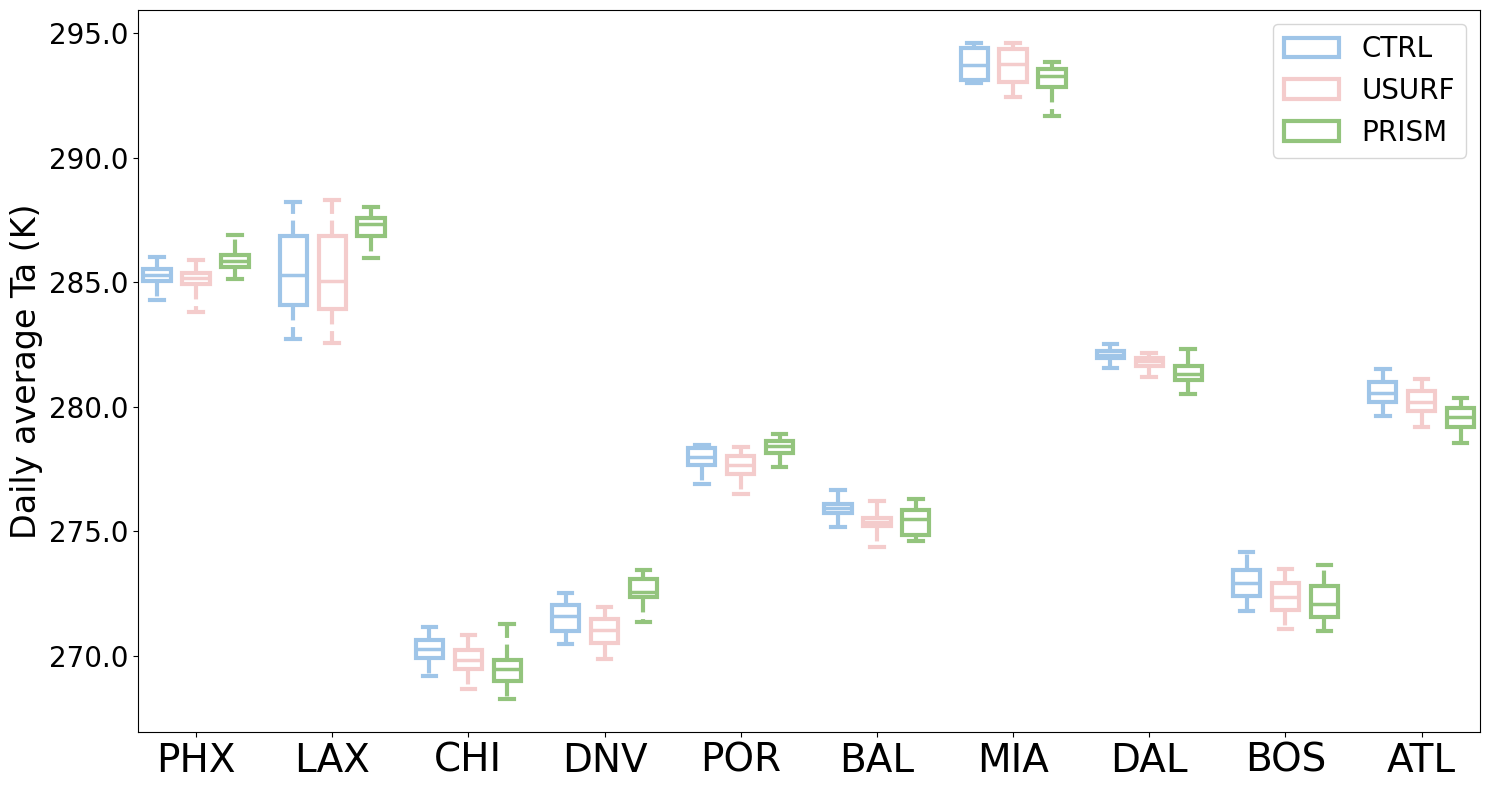

In [14]:
var_name='TSA_U'
ylabel='Daily average Ta (K)'
fig,city_stats=boxplot_PRISM(var_name, PRISM_DJF_xr, ylabel,'DJF')
fig.savefig(plot_path+'PRISM_CLM_2010_2014_DJF_daily_TSA_U_boxplot_waterMask_c250527.png', format='png', bbox_inches='tight', dpi=400)
city_stats

,PHX,LAX,CHI,DNV,POR,BAL,MIA,DAL,BOS,ATL,average
R_ctrl,-0.562798,0.651670,0.904789,-0.564314,0.032301,0.294907,0.565416,0.457910,0.724675,0.774688,0.327924
RMSE_ctrl,1.068482,1.746343,1.594698,1.127908,0.720911,1.294773,0.946162,1.500618,1.825478,2.038319,1.386369
MAE_ctrl,0.947423,1.439219,1.531671,0.892172,0.593785,0.998029,0.762647,1.400541,1.704867,2.017405,1.228776
R_test,-0.625240,0.679951,0.907751,-0.530359,-0.029472,0.381967,0.612540,0.499761,0.793415,0.778485,0.346880
RMSE_test,1.095767,1.823390,1.092773,1.077747,0.713713,1.006834,0.971846,1.256260,1.299718,1.877626,1.221567
MAE_test,0.958729,1.527232,1.030972,0.850765,0.604450,0.845780,0.787331,1.144188,1.197434,1.855326,1.080221


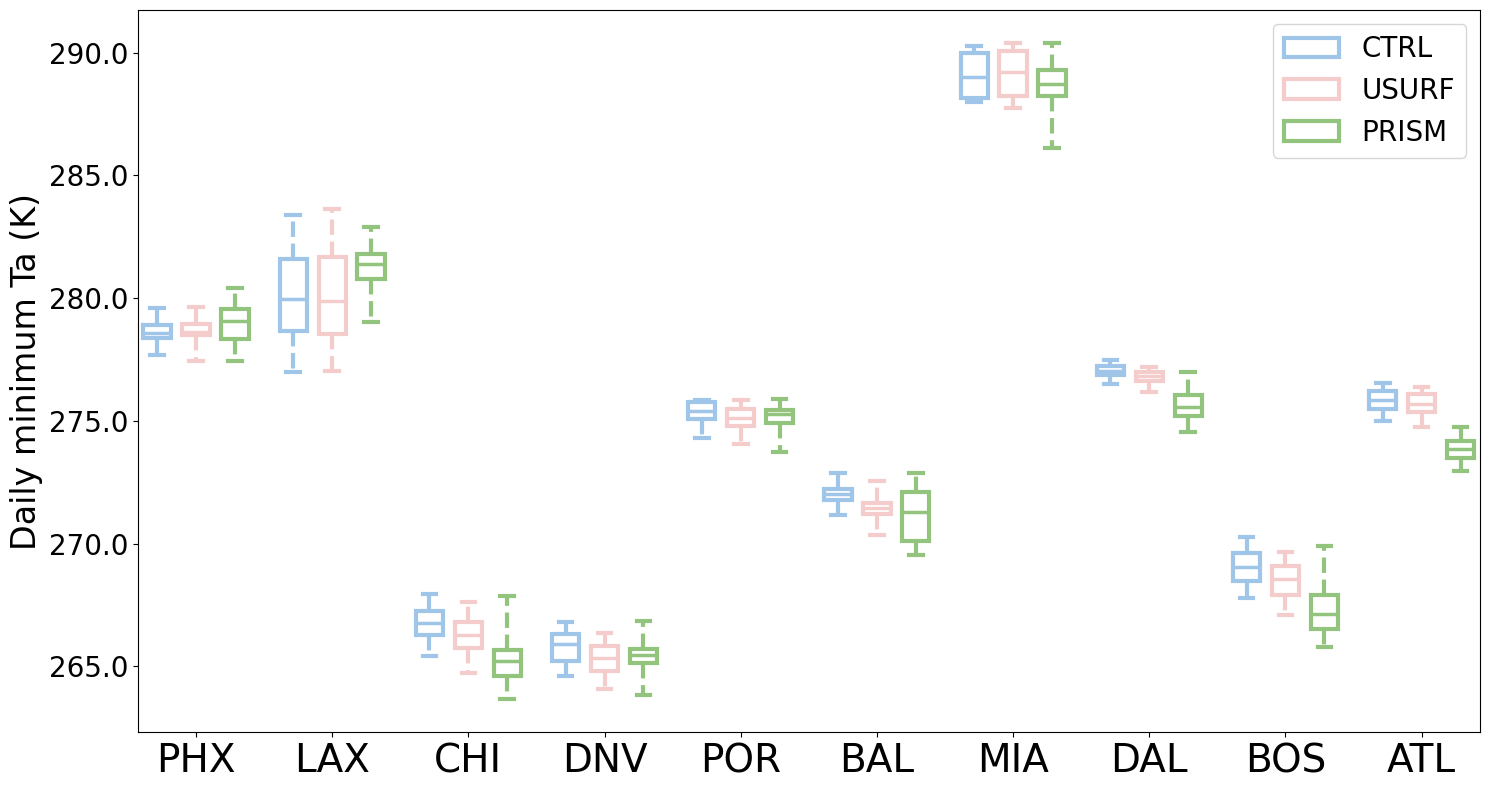

In [17]:
var_name='TREFMNAV_U'
ylabel='Daily minimum Ta (K)'
fig,city_stats=boxplot_PRISM(var_name, PRISM_DJF_Tmin_xr, ylabel,'DJF')
fig.savefig(plot_path+'PRISM_CLM_2010_2014_DJF_daily_TREFMNAV_U_boxplot_waterMask_c250527.png', format='png', bbox_inches='tight', dpi=400)
city_stats

,PHX,LAX,CHI,DNV,POR,BAL,MIA,DAL,BOS,ATL,average
R_ctrl,0.591050,-0.352724,0.799650,-0.791480,0.463288,0.305833,0.675656,0.806963,0.949280,0.936932,0.438445
RMSE_ctrl,1.192954,1.607702,0.935141,1.340493,0.774156,1.430490,2.167504,2.402633,0.586092,1.730522,1.416769
MAE_ctrl,1.127228,1.403910,0.895053,1.064065,0.679020,1.386962,2.136230,2.393355,0.555561,1.718108,1.335949
R_test,0.644366,-0.357471,0.843932,-0.719354,0.484295,0.306995,0.548874,0.751786,0.918245,0.925299,0.434697
RMSE_test,0.787684,1.676174,0.576595,1.076260,0.543733,0.879809,1.826086,2.031331,0.259700,1.072653,1.073002
MAE_test,0.696816,1.505821,0.529172,0.963737,0.425945,0.790686,1.777294,2.017699,0.212568,1.048291,0.996803


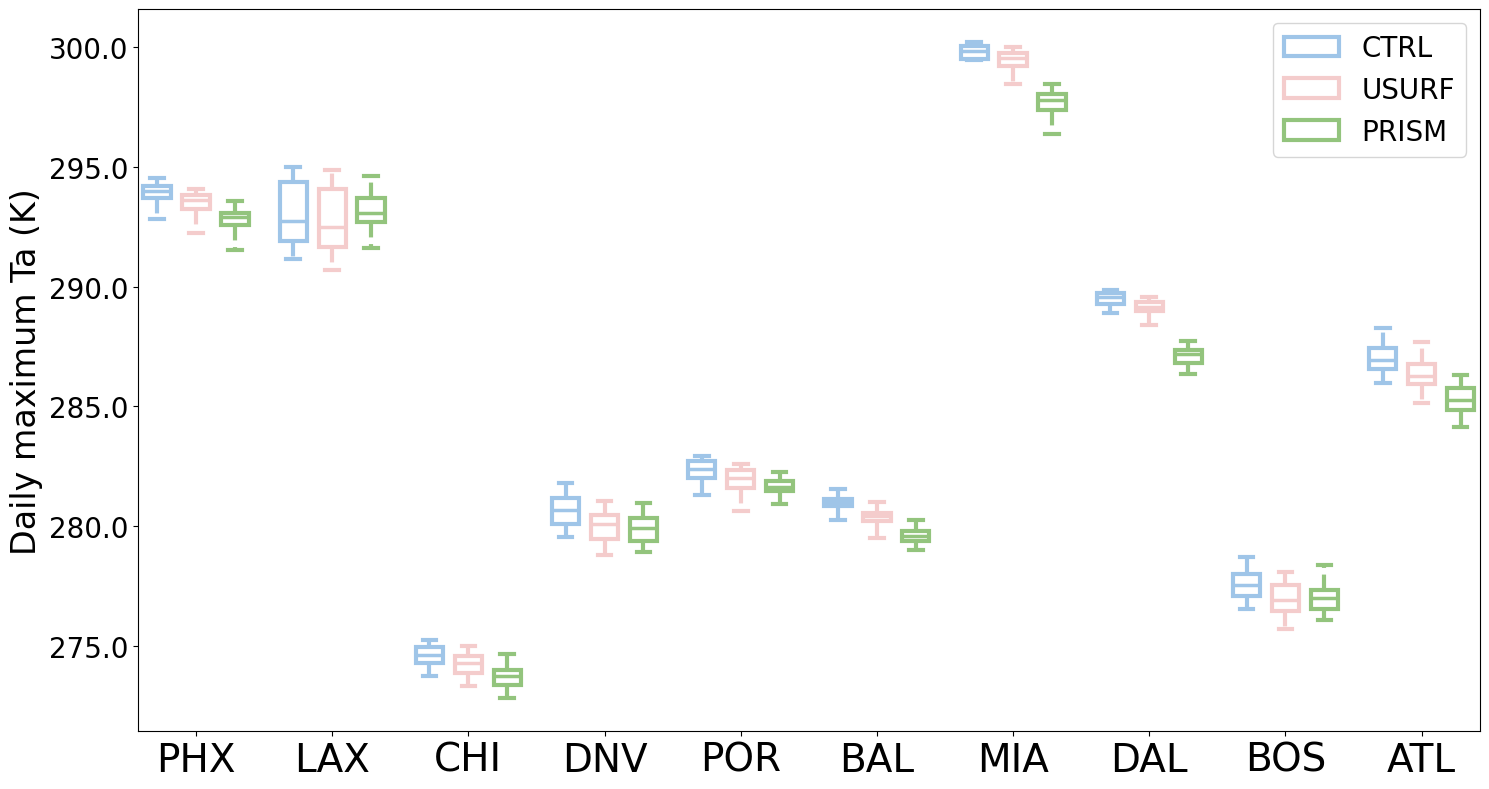

In [18]:
var_name='TREFMXAV_U'
ylabel='Daily maximum Ta (K)'
fig,city_stats=boxplot_PRISM(var_name, PRISM_DJF_Tmax_xr, ylabel,'DJF')
fig.savefig(plot_path+'PRISM_CLM_2010_2014_DJF_daily_TREFMXAV_U_boxplot_waterMask_c250527.png', format='png', bbox_inches='tight', dpi=400)
city_stats